$Scope:$<br>
**This project is about analysing and predicting propensity of persistency in an insurance company. In this scope, I will build a simple model to predict current policies would be renewal or not in the next payment term.**<br>
**Due to some restrict data protections, I will not provide true data values. So this is just about how do I do it!**<br>

**Author:**  Nguyen Ba Viet Ha (firefox94)<br>
**Role:**  Data Analyst - Data Scientist<br>
**Require:**  Basic knowledge of Python / Basic knowledge of ML model<br>

# Input necessary library!

In [ ]:
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')

# Create a connection to my SQL server which I use as a sandbox:
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=SERVER;DATABASE=DATABASE;UID=USERID;PWD=Password')

# Create a function to help me quicky call out some metrics to evaluate:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
import math 
def getScores( y_test, y_predict):
    mse = mean_squared_error(y_test,y_predict)
    rmse = math.sqrt(mse)
    mae = median_absolute_error(y_test,y_predict)
    r2 = r2_score(y_test,y_predict)
    result = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2_Score": r2 }
    return result

## I. Prepare & Clean Data Input

In [2]:
# Create a query to get data source from my SQL server:
query_db = f"""
SELECT [MB_KHOI],[MB_TEN_VUNG_PBO],[MB_PHAN_KHUC_KH],[MB_CREDIT_LIMIT_CC],[MB_SDBQ_CASA_6M],[MB_SDBQ_TK_3M],[MB_SDBQ_TK_1M],[MB_FLAG_KH_ACTIVE],[MB_SODU_CASA],[MB_SDBQ_CASA_3M],[MB_SDBQ_CASA_1M],[MB_SODU_TK],[MB_FLAG_TK_3M],[MB_TONGDUNO],[MB_FLAG_TKTT],[MB_FLAG_TGTK],[MB_FLAG_CREDIT_CARD],[MB_FLAG_DEBIT_CARD],[MB_FLAG_NHADAT],[MB_FLAG_NHA_DA],[MB_FLAG_SXKD],[MB_FLAG_OTO],[MB_FLAG_TDTSDB],[MB_FLAG_STK],[MB_FLAG_CK],[MB_FLAG_KHAC],[MB_FLAG_MBAL],[MB_FLAG_SPDT],[MB_FLAG_DEBIT_QT],[MB_FLAG_KIEUHOI_YTD],[MB_DUNO_NHADAT],[MB_DUNO_NHA_DA],[MB_DUNO_SXKD],[MB_DUNO_OTO],[MB_DUNO_TDTSDB],[MB_DUNO_STK],[MB_DUNO_CK],[MB_DUNO_VISA],[MB_DUNO_KHAC],[MB_SLSP],[MB_SLDV],[MB_FLAG_CO_TOPUP],[MB_DS_APE_2021],[MB_DS_FYP_2021],[MB_SLHD_2021],[MB_LOAI_KH],[MB_PHANNHOM_KH],[MB_SLSP_MBAL],[MB_FLAG_PER_THUCTE],[MBAL_HOLDER_ID],[MB_DEBT_GROUP],[MBAL_NO_RIDER],[MBAL_NO_CLAIM],[MBAL_NO_PAID_CLAIM],[MBAL_CLAIM_PAID_AMT],[MBAL_NO_CLAIM_ACCUMULATED],[MBAL_NO_PAID_CLAIM_ACCUMULATED],[MBAL_CLAIM_PAID_AMT_ACCUMULATED],[MBAL_HOLDER_CIVIL_STATUS],[MBAL_HOLDER_LOCATION],[MBAL_CUST_TENURE],[CUST_UPSALE_FLAG] FROM [MBALPOLICY].[analytics].[upsale_crosssale_final] where [TXN_YEAR]=2021 and [MB_KHOI]in('INDIV','NHS')
"""

In [4]:
# Get data source with Pandas:
df_upsale_2021 = pd.read_sql(query_db,con=conn)
df_upsale_2021

,MB_KHOI,MB_TEN_VUNG_PBO,MB_PHAN_KHUC_KH,MB_CREDIT_LIMIT_CC,MB_SDBQ_CASA_6M,MB_SDBQ_TK_3M,MB_SDBQ_TK_1M,MB_FLAG_KH_ACTIVE,MB_SODU_CASA,MB_SDBQ_CASA_3M,...,MBAL_NO_CLAIM,MBAL_NO_PAID_CLAIM,MBAL_CLAIM_PAID_AMT,MBAL_NO_CLAIM_ACCUMULATED,MBAL_NO_PAID_CLAIM_ACCUMULATED,MBAL_CLAIM_PAID_AMT_ACCUMULATED,MBAL_HOLDER_CIVIL_STATUS,MBAL_HOLDER_LOCATION,MBAL_CUST_TENURE,CUST_UPSALE_FLAG
0,INDIV,VUNG MIEN BAC,VIP,0.0,3.610298e+07,0.000000e+00,0.0,1,2709716.0,1.178853e+07,...,0,0,0.0,0,0,0.0,Married,HAI PHONG,0,0
1,INDIV,VUNG HA NOI 2,VIP,30000000.0,1.090826e+03,3.000875e+08,300259776.0,1,691.0,6.910000e+02,...,0,0,0.0,0,0,0.0,Married,HA NOI,0,0
2,INDIV,VUNG MIEN TRUNG,VIP,100000000.0,3.326200e+08,1.077625e+09,458330560.0,1,407009536.0,3.391443e+08,...,0,0,0.0,0,0,0.0,Married,KHANH HOA,0,0
3,INDIV,VUNG HCM 1,VIP,200000000.0,1.117808e+06,0.000000e+00,0.0,1,130549.0,1.855181e+06,...,0,0,0.0,0,0,0.0,Married,HO CHI MINH,0,0
4,INDIV,VUNG HA NOI 2,MASS,0.0,3.707526e+04,0.000000e+00,0.0,1,6.0,2.174051e+04,...,0,0,0.0,0,0,0.0,Married,HA NOI,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33785,INDIV,VUNG MIEN BAC,MASS,0.0,1.303325e+06,0.000000e+00,0.0,1,500.0,1.222685e+06,...,0,0,0.0,0,0,0.0,Single,HAI DUONG,0,0
33786,INDIV,VUNG HA NOI 2,VIP,101000000.0,2.467110e+07,6.610837e+08,665314240.0,1,3803345.0,1.460858e+07,...,0,0,0.0,0,0,0.0,Married,HA NOI,0,0
33787,INDIV,VUNG MIEN BAC,VIP,100000000.0,4.475116e+06,0.000000e+00,0.0,1,2593853.0,5.219868e+06,...,0,0,0.0,0,0,0.0,Married,HAI PHONG,0,0
33788,INDIV,VUNG MIEN TRUNG,VIP,200000000.0,4.283361e+07,0.000000e+00,0.0,1,90944592.0,5.936219e+07,...,0,0,0.0,0,0,0.0,Single,BA RIA-VUNG TAU,0,0


In [3]:
# Customize location data into 3 different regions:
MB = ['Bac Giang','Bac Kan','Bac Ninh','Cao Bang','Dien Bien','Ha Giang','Ha Nam','Ha Noi','Hai Duong','Hai Phong','Hoa Binh','Hung Yen','Lai Chau','Lang Son','Lao Cai','Nam Dinh','Ninh Binh','Phu Tho','Quang Ninh','Son La','Thai Binh','Thai Nguyen','Tuyen Quang','Vinh Phuc','Yen Bai']
MT = ['Binh Dinh','Binh Thuan','Da Nang','Dak Lak','Dak Nong','Gia Lai','Ha Tinh','Khanh Hoa','Kon Tum','Lam Dong','Nghe An','Ninh Thuan','Phu Yen','Quang Binh','Quang Nam','Quang Ngai','Quang Tri','Thanh Hoa','Thua Thien Hue']

def convert(x):
    if x in list(np.char.lower(MB)):
        return 'MB'
    elif x in list(np.char.lower(MT)):
        return 'MT'
    else:
        return 'MN'
    

north = ['HOI SO','VUNG DONG BAC BO','VUNG HA NOI 1','VUNG HA NOI 2','VUNG MIEN BAC','VUNG TAY BAC BO']
south = ['VUNG DONG NAM BO','VUNG HCM 1','VUNG HCM 2','VUNG MIEN NAM','VUNG TAY NAM BO']
mid = ['VUNG MIEN TRUNG']

def vung(x):
    if x in north:
        return 'MB'
    elif x in south:
        return 'MN'
    else:
        return 'MT'

In [5]:
# Summarize of null values
df_upsale_2021.isnull().sum()

MB_KHOI                              0
MB_TEN_VUNG_PBO                      0
MB_PHAN_KHUC_KH                      0
MB_CREDIT_LIMIT_CC                   0
MB_SDBQ_CASA_6M                      0
                                  ... 
MBAL_CLAIM_PAID_AMT_ACCUMULATED      0
MBAL_HOLDER_CIVIL_STATUS             0
MBAL_HOLDER_LOCATION               331
MBAL_CUST_TENURE                     0
CUST_UPSALE_FLAG                     0
Length: 62, dtype: int64

In [6]:
# check if any columns got null values:
for column in df_upsale_2021.columns:
        if df_upsale_2021[column].isnull().sum() != 0:
            print(column,df_upsale_2021[column].isnull().sum())

MBAL_NO_RIDER 30
MBAL_HOLDER_LOCATION 331


In [7]:
# Transform data into 2 parts: Data got null values and Data does not get null values to normalize
not_null = df_upsale_2021[~df_upsale_2021['MBAL_HOLDER_LOCATION'].isnull()]
not_null['MBAL_HOLDER_LOCATION'] = not_null['MBAL_HOLDER_LOCATION'].apply(lambda y: y.lower())
not_null['region'] = not_null['MBAL_HOLDER_LOCATION'].apply(convert)

null = df_upsale_2021[df_upsale_2021['MBAL_HOLDER_LOCATION'].isnull()]
null['region'] = null['MB_TEN_VUNG_PBO'].apply(vung)

df_total = pd.concat([not_null,null],axis=0)

df_total = df_total.drop(columns=['MB_TEN_VUNG_PBO','MBAL_HOLDER_LOCATION'])

In [9]:
# Show all columns name
df_total.columns 

Index(['MB_KHOI', 'MB_PHAN_KHUC_KH', 'MB_CREDIT_LIMIT_CC', 'MB_SDBQ_CASA_6M',
       'MB_SDBQ_TK_3M', 'MB_SDBQ_TK_1M', 'MB_FLAG_KH_ACTIVE', 'MB_SODU_CASA',
       'MB_SDBQ_CASA_3M', 'MB_SDBQ_CASA_1M', 'MB_SODU_TK', 'MB_FLAG_TK_3M',
       'MB_TONGDUNO', 'MB_FLAG_TKTT', 'MB_FLAG_TGTK', 'MB_FLAG_CREDIT_CARD',
       'MB_FLAG_DEBIT_CARD', 'MB_FLAG_NHADAT', 'MB_FLAG_NHA_DA',
       'MB_FLAG_SXKD', 'MB_FLAG_OTO', 'MB_FLAG_TDTSDB', 'MB_FLAG_STK',
       'MB_FLAG_CK', 'MB_FLAG_KHAC', 'MB_FLAG_MBAL', 'MB_FLAG_SPDT',
       'MB_FLAG_DEBIT_QT', 'MB_FLAG_KIEUHOI_YTD', 'MB_DUNO_NHADAT',
       'MB_DUNO_NHA_DA', 'MB_DUNO_SXKD', 'MB_DUNO_OTO', 'MB_DUNO_TDTSDB',
       'MB_DUNO_STK', 'MB_DUNO_CK', 'MB_DUNO_VISA', 'MB_DUNO_KHAC', 'MB_SLSP',
       'MB_SLDV', 'MB_FLAG_CO_TOPUP', 'MB_DS_APE_2021', 'MB_DS_FYP_2021',
       'MB_SLHD_2021', 'MB_LOAI_KH', 'MB_PHANNHOM_KH', 'MB_SLSP_MBAL',
       'MB_FLAG_PER_THUCTE', 'MBAL_HOLDER_ID', 'MB_DEBT_GROUP',
       'MBAL_NO_RIDER', 'MBAL_NO_CLAIM', 'MBAL_NO_PAID_C

##### Load add on data from db to get some more information of policies (timeline 12/2021):

In [10]:
query_policy = f"""
  SELECT D.*,E.So_HD,E.Sum_APE FROM (  select distinct   A.[Policy Holder ID][MBAL_HOLDER_ID],  [Policyholder's Gender],  case when DATEDIFF(year,A.[BOD],A.[Issued Date]) between 18 and 25 then '01'	   when DATEDIFF(year,A.[BOD],A.[Issued Date]) between 26 and 35 then '02'	   when DATEDIFF(year,A.[BOD],A.[Issued Date]) between 36 and 50 then '03'	   when DATEDIFF(year,A.[BOD],A.[Issued Date]) between 51 and 65 then '04'	   when DATEDIFF(year,A.[BOD],A.[Issued Date]) > 65 then '05'	   END as [Nhom_tuoi],	C.[Premium Term],	case when A.[Premium Payment Frequency] = 'Single Premium' then '0'		 else LEFT(A.[Premium Payment Frequency],2) END as [Premium_Payment_Frequency],	A.[Policy Status],	case when B.[Pending Group] is null then '0' 	     when (B.[Pending Group] = 'CAL' or B.[Pending Group] = '') then '3'		 when B.[Pending Group] in ('OTE','MED') then '2'		 when B.[Pending Group] in ('DOC','OTH','SPE') then '1'	END as [Pending_status]  FROM [MBALPOLICY].[dbo].[Policy_202112] A  left join  (select distinct [Policy Number],[Pending Group] FROM [MBALPOLICY].[BW].[V_OP16_Data]) B  on A.[Policy Number] = B.[Policy Number]  left join  (select distinct [Policy Number],[Policy Holder ID],[Premium Term] FROM [MBALPOLICY].[dbo].[Rider_Details_202112]   where [Main Rider Product Name] in ('Child Educational Endowment','Endowment','MBAL UL Regular Pay 3.0','MBAL Universal Life','MBAL Universal Life 2020','Standalone Personal Accident 101','Standalone Personal Accident 102','Whole Of Life ULK - WULKRP','Cancer Benefit')  )C  on A.[Policy Number] = C.[Policy Number] and A.[Policy Holder ID] = C.[Policy Holder ID]  where A.[Premium Term] <> 0 and A.[Is Top Up] is null  ) D  left join  (select [Policy Holder ID],count(distinct [Policy Number])[So_HD],SUM([APE])[Sum_APE] FROM [MBALPOLICY].[dbo].[Policy_202112]  where [Is Top Up] is null  group by [Policy Holder ID]) E  on D.MBAL_HOLDER_ID = E.[Policy Holder ID]
"""

In [11]:
df_policy = pd.read_sql(query_policy,con=conn)
df_policy

,MBAL_HOLDER_ID,Policyholder's Gender,Nhom_tuoi,Premium Term,Premium_Payment_Frequency,Policy Status,Pending_status,So_HD,Sum_APE
0,0001000013,Female,03,2.0,12,Active,0,1,780000.0
1,0001000055,Male,03,0.0,01,Active,2,3,153175000.0
2,0001000055,Male,03,5.0,01,Active,0,3,153175000.0
3,0001000055,Male,03,65.0,01,Active,2,3,153175000.0
4,0001000055,Male,03,1.0,12,Active,0,3,153175000.0
...,...,...,...,...,...,...,...,...,...
351792,0200162623,Male,03,63.0,01,Lapse,0,1,10000000.0
351793,0200162631,Female,02,68.0,01,Lapse,0,1,20000000.0
351794,0200162714,Male,02,71.0,01,Lapse,0,1,10000000.0
351795,0200162851,Female,03,62.0,01,Active,1,2,12000000.0


Merge 2 data sources into 1 data source:

In [14]:
df_merge = pd.merge(df_total,df_policy,how='left',on='MBAL_HOLDER_ID')
df_merge = df_merge.drop(columns=['MBAL_HOLDER_ID'])
df_merge  #This dataframe have 68 features with some features about policy information

,MB_KHOI,MB_PHAN_KHUC_KH,MB_CREDIT_LIMIT_CC,MB_SDBQ_CASA_6M,MB_SDBQ_TK_3M,MB_SDBQ_TK_1M,MB_FLAG_KH_ACTIVE,MB_SODU_CASA,MB_SDBQ_CASA_3M,MB_SDBQ_CASA_1M,...,CUST_UPSALE_FLAG,region,Policyholder's Gender,Nhom_tuoi,Premium Term,Premium_Payment_Frequency,Policy Status,Pending_status,So_HD,Sum_APE
0,INDIV,VIP,0.0,3.610298e+07,0.000000e+00,0.0,1,2709716.0,1.178853e+07,1.153869e+07,...,0,MB,Male,03,61.0,01,Active,1,1.0,30000000.0
1,INDIV,VIP,30000000.0,1.090826e+03,3.000875e+08,300259776.0,1,691.0,6.910000e+02,6.910000e+02,...,0,MB,Female,04,48.0,01,Active,0,1.0,18000000.0
2,INDIV,VIP,100000000.0,3.326200e+08,1.077625e+09,458330560.0,1,407009536.0,3.391443e+08,6.295462e+08,...,0,MT,Female,03,52.0,01,Active,0,1.0,30000000.0
3,INDIV,VIP,200000000.0,1.117808e+06,0.000000e+00,0.0,1,130549.0,1.855181e+06,3.873062e+05,...,0,MN,Male,02,68.0,01,Active,0,1.0,50000000.0
4,INDIV,MASS,0.0,3.707526e+04,0.000000e+00,0.0,1,6.0,2.174051e+04,6.451826e+04,...,0,MB,Male,02,73.0,01,Active,0,1.0,12000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44048,INDIV,VIP,200000000.0,1.222250e+08,4.565881e+06,0.0,1,36281616.0,2.600879e+07,2.383796e+07,...,0,MB,Male,02,73.0,01,Active,0,1.0,15000000.0
44049,INDIV,VIP,35000000.0,8.479791e+05,0.000000e+00,0.0,1,138006.0,1.090732e+06,5.437092e+05,...,0,MN,Female,03,59.0,01,Active,0,1.0,12000000.0
44050,INDIV,MASS,30000000.0,9.312354e+05,0.000000e+00,0.0,1,4009575.0,1.010904e+06,1.279810e+06,...,0,MN,Male,02,68.0,01,Active,1,1.0,12000000.0
44051,INDIV,VIP,20000000.0,1.050187e+07,0.000000e+00,0.0,1,14209067.0,1.610872e+07,3.274732e+07,...,0,MN,Male,02,75.0,01,Active,0,1.0,15000000.0


In [15]:
df_merge.columns

Index(['MB_KHOI', 'MB_PHAN_KHUC_KH', 'MB_CREDIT_LIMIT_CC', 'MB_SDBQ_CASA_6M',
       'MB_SDBQ_TK_3M', 'MB_SDBQ_TK_1M', 'MB_FLAG_KH_ACTIVE', 'MB_SODU_CASA',
       'MB_SDBQ_CASA_3M', 'MB_SDBQ_CASA_1M', 'MB_SODU_TK', 'MB_FLAG_TK_3M',
       'MB_TONGDUNO', 'MB_FLAG_TKTT', 'MB_FLAG_TGTK', 'MB_FLAG_CREDIT_CARD',
       'MB_FLAG_DEBIT_CARD', 'MB_FLAG_NHADAT', 'MB_FLAG_NHA_DA',
       'MB_FLAG_SXKD', 'MB_FLAG_OTO', 'MB_FLAG_TDTSDB', 'MB_FLAG_STK',
       'MB_FLAG_CK', 'MB_FLAG_KHAC', 'MB_FLAG_MBAL', 'MB_FLAG_SPDT',
       'MB_FLAG_DEBIT_QT', 'MB_FLAG_KIEUHOI_YTD', 'MB_DUNO_NHADAT',
       'MB_DUNO_NHA_DA', 'MB_DUNO_SXKD', 'MB_DUNO_OTO', 'MB_DUNO_TDTSDB',
       'MB_DUNO_STK', 'MB_DUNO_CK', 'MB_DUNO_VISA', 'MB_DUNO_KHAC', 'MB_SLSP',
       'MB_SLDV', 'MB_FLAG_CO_TOPUP', 'MB_DS_APE_2021', 'MB_DS_FYP_2021',
       'MB_SLHD_2021', 'MB_LOAI_KH', 'MB_PHANNHOM_KH', 'MB_SLSP_MBAL',
       'MB_FLAG_PER_THUCTE', 'MB_DEBT_GROUP', 'MBAL_NO_RIDER', 'MBAL_NO_CLAIM',
       'MBAL_NO_PAID_CLAIM', 'MBAL_CLAIM

In [16]:
dict_convert = {
    "MB_KHOI": str, "MB_PHAN_KHUC_KH": str, "MB_CREDIT_LIMIT_CC": float, "MB_SDBQ_CASA_6M": float,
       "MB_SDBQ_TK_3M": float, "MB_SDBQ_TK_1M": float, "MB_FLAG_KH_ACTIVE": float, "MB_SODU_CASA": float,
       "MB_SDBQ_CASA_3M": float, "MB_SDBQ_CASA_1M": float, "MB_SODU_TK": float, "MB_FLAG_TK_3M": float,
       "MB_TONGDUNO": float, "MB_FLAG_TKTT": float, "MB_FLAG_TGTK": float, "MB_FLAG_CREDIT_CARD": float,
       "MB_FLAG_DEBIT_CARD": float, "MB_FLAG_NHADAT": float, "MB_FLAG_NHA_DA": float,
       "MB_FLAG_SXKD": float, "MB_FLAG_OTO": float, "MB_FLAG_TDTSDB": float, "MB_FLAG_STK": float,
       "MB_FLAG_CK": float, "MB_FLAG_KHAC": float, "MB_FLAG_MBAL": float, "MB_FLAG_SPDT": float,
       "MB_FLAG_DEBIT_QT": float, "MB_FLAG_KIEUHOI_YTD": float, "MB_DUNO_NHADAT": float,
       "MB_DUNO_NHA_DA": float, "MB_DUNO_SXKD": float, "MB_DUNO_OTO": float, "MB_DUNO_TDTSDB": float,
       "MB_DUNO_STK": float, "MB_DUNO_CK": float, "MB_DUNO_VISA": float, "MB_DUNO_KHAC": float, "MB_SLSP":float,
       "MB_SLDV": float, "MB_FLAG_CO_TOPUP": float, "MB_DS_APE_2021": float, "MB_DS_FYP_2021": float,
       "MB_SLHD_2021": float, "MB_LOAI_KH": str, "MB_PHANNHOM_KH": str, "MB_SLSP_MBAL": float,
       "MB_FLAG_PER_THUCTE": float, "MB_DEBT_GROUP": float,
       "MBAL_NO_RIDER": float, "MBAL_NO_CLAIM": float, "MBAL_NO_PAID_CLAIM": float,
       "MBAL_CLAIM_PAID_AMT": float, "MBAL_NO_CLAIM_ACCUMULATED": float,
       "MBAL_NO_PAID_CLAIM_ACCUMULATED": float, "MBAL_CLAIM_PAID_AMT_ACCUMULATED": float,
       "MBAL_HOLDER_CIVIL_STATUS": str, "MBAL_CUST_TENURE": float, "CUST_UPSALE_FLAG": float,
       "region": str, "Policyholder's Gender": str, "Nhom_tuoi": float, "Premium Term": float,
       "Premium_Payment_Frequency": float, "Policy Status": str, "Pending_status": float, "So_HD": float,
       "Sum_APE": float
}

In [17]:
df_merge = df_merge.astype(dict_convert)
df_merge = df_merge[df_merge["Policyholder's Gender"]!='nan']
df_merge

,MB_KHOI,MB_PHAN_KHUC_KH,MB_CREDIT_LIMIT_CC,MB_SDBQ_CASA_6M,MB_SDBQ_TK_3M,MB_SDBQ_TK_1M,MB_FLAG_KH_ACTIVE,MB_SODU_CASA,MB_SDBQ_CASA_3M,MB_SDBQ_CASA_1M,...,CUST_UPSALE_FLAG,region,Policyholder's Gender,Nhom_tuoi,Premium Term,Premium_Payment_Frequency,Policy Status,Pending_status,So_HD,Sum_APE
0,INDIV,VIP,0.0,3.610298e+07,0.000000e+00,0.0,1.0,2709716.0,1.178853e+07,1.153869e+07,...,0.0,MB,Male,3.0,61.0,1.0,Active,1.0,1.0,30000000.0
1,INDIV,VIP,30000000.0,1.090826e+03,3.000875e+08,300259776.0,1.0,691.0,6.910000e+02,6.910000e+02,...,0.0,MB,Female,4.0,48.0,1.0,Active,0.0,1.0,18000000.0
2,INDIV,VIP,100000000.0,3.326200e+08,1.077625e+09,458330560.0,1.0,407009536.0,3.391443e+08,6.295462e+08,...,0.0,MT,Female,3.0,52.0,1.0,Active,0.0,1.0,30000000.0
3,INDIV,VIP,200000000.0,1.117808e+06,0.000000e+00,0.0,1.0,130549.0,1.855181e+06,3.873062e+05,...,0.0,MN,Male,2.0,68.0,1.0,Active,0.0,1.0,50000000.0
4,INDIV,MASS,0.0,3.707526e+04,0.000000e+00,0.0,1.0,6.0,2.174051e+04,6.451826e+04,...,0.0,MB,Male,2.0,73.0,1.0,Active,0.0,1.0,12000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44048,INDIV,VIP,200000000.0,1.222250e+08,4.565881e+06,0.0,1.0,36281616.0,2.600879e+07,2.383796e+07,...,0.0,MB,Male,2.0,73.0,1.0,Active,0.0,1.0,15000000.0
44049,INDIV,VIP,35000000.0,8.479791e+05,0.000000e+00,0.0,1.0,138006.0,1.090732e+06,5.437092e+05,...,0.0,MN,Female,3.0,59.0,1.0,Active,0.0,1.0,12000000.0
44050,INDIV,MASS,30000000.0,9.312354e+05,0.000000e+00,0.0,1.0,4009575.0,1.010904e+06,1.279810e+06,...,0.0,MN,Male,2.0,68.0,1.0,Active,1.0,1.0,12000000.0
44051,INDIV,VIP,20000000.0,1.050187e+07,0.000000e+00,0.0,1.0,14209067.0,1.610872e+07,3.274732e+07,...,0.0,MN,Male,2.0,75.0,1.0,Active,0.0,1.0,15000000.0


In [18]:
### Replace null value with mean of that column:

for column in df_merge.columns:
        if df_merge[column].isnull().sum() != 0:
            print(column,df_merge[column].isnull().sum())
            df_merge[column]=df_merge[column].fillna(df_merge[column].mean(axis=0))

In [19]:
### check if there are still be null value:

for column in df_merge.columns:
        while df_merge[column].isnull().sum() != 0:
            print(column,df_merge[column].isnull().sum())
        else:
            print('No null values remain. You are good to go!')
            break

No null values remain. You are good to go!


## II. Do some EDA stuffs:

*** _Single variable_

A. Simple describe basic information in dataset

In [20]:
df_merge.describe

<bound method NDFrame.describe of       MB_KHOI MB_PHAN_KHUC_KH  MB_CREDIT_LIMIT_CC  MB_SDBQ_CASA_6M  \
0       INDIV             VIP                 0.0     3.610298e+07   
1       INDIV             VIP          30000000.0     1.090826e+03   
2       INDIV             VIP         100000000.0     3.326200e+08   
3       INDIV             VIP         200000000.0     1.117808e+06   
4       INDIV            MASS                 0.0     3.707526e+04   
...       ...             ...                 ...              ...   
44048   INDIV             VIP         200000000.0     1.222250e+08   
44049   INDIV             VIP          35000000.0     8.479791e+05   
44050   INDIV            MASS          30000000.0     9.312354e+05   
44051   INDIV             VIP          20000000.0     1.050187e+07   
44052   INDIV             VIP         300000000.0     1.774681e+06   

       MB_SDBQ_TK_3M  MB_SDBQ_TK_1M  MB_FLAG_KH_ACTIVE  MB_SODU_CASA  \
0       0.000000e+00            0.0                1.

<function matplotlib.pyplot.show(close=None, block=None)>

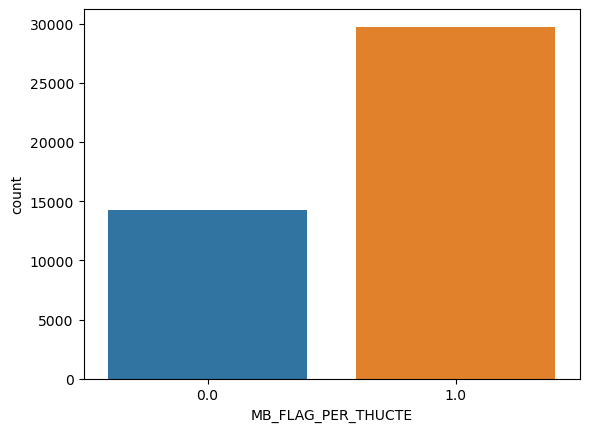

In [21]:
sns.countplot(data=df_merge,x=df_merge['MB_FLAG_PER_THUCTE'])
plt.show

In [22]:
df_merge['MB_FLAG_PER_THUCTE'].value_counts()

1.0    29747
0.0    14276
Name: MB_FLAG_PER_THUCTE, dtype: int64

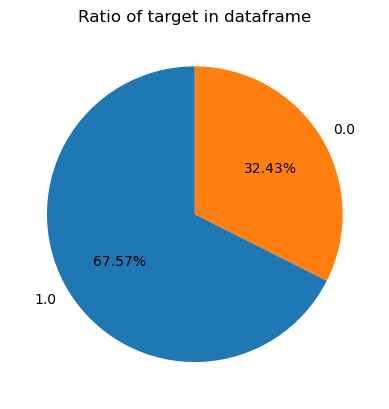

In [23]:
# Distribution of target value in dataframe
plt.pie(df_merge['MB_FLAG_PER_THUCTE'].value_counts(), labels=df_merge['MB_FLAG_PER_THUCTE'].value_counts().index, startangle=90, autopct='%.2f%%')
plt.title('Ratio of target in dataframe')
plt.show()

**=> The ratio of 2 classes is about 1:2 with major distribution belongs to Not_Per class. We might consider no need to balance dataset; but in this demo I will still use some techniques to solve unbalance dataset**

B. Region view:

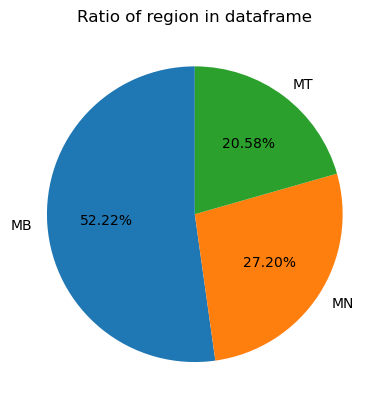

In [25]:
plt.pie(df_merge['region'].value_counts(), labels=df_merge['region'].value_counts().index, startangle=90, autopct='%.2f%%')
plt.title('Ratio of region in dataframe')
plt.show()

In [26]:
df_merge['region'].value_counts()

MB    22989
MN    11976
MT     9058
Name: region, dtype: int64

**=> Mostly MB (North side) in our dataset**

C. APE correlative with Per status

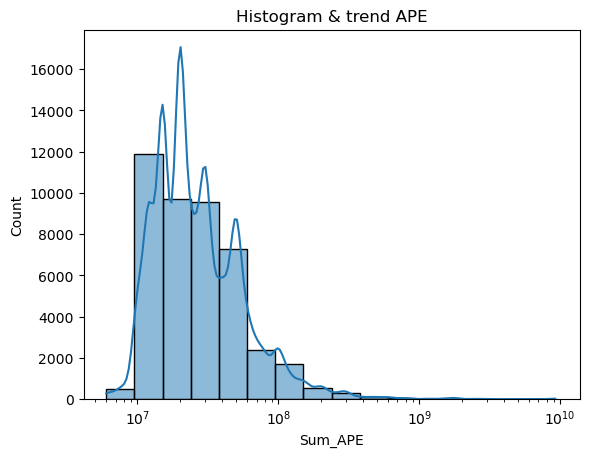

In [27]:
sns.histplot(data=df_merge, x='Sum_APE', kde=True, bins=100, binwidth=0.2,log_scale=True)
plt.title('Histogram & trend APE')
plt.show()
# => Max APE ~ 9B & Min APE = 6M
# => APE module in range 10M - 30M

<function matplotlib.pyplot.show(close=None, block=None)>

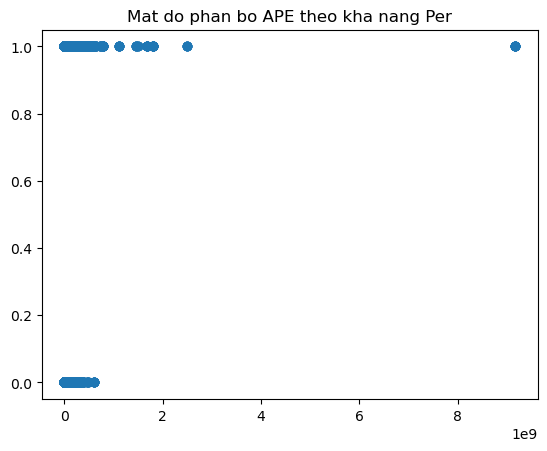

In [29]:
plt.scatter(df_merge['Sum_APE'],df_merge['MB_FLAG_PER_THUCTE'])
plt.title('Mat do phan bo APE theo kha nang Per')
plt.show
# => More APE means more chance to renewal

D. Age/Sex - Per view:

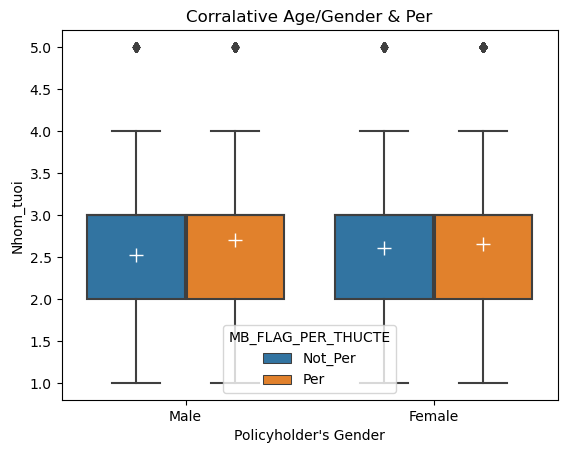

In [31]:
meanprops = {
    'marker': '+',
    'markeredgecolor': 'white',
    'markersize': '10'
}
sns.boxplot(data=df_temp, x="Policyholder's Gender", y='Nhom_tuoi', hue='MB_FLAG_PER_THUCTE',showmeans=True,meanprops=meanprops)
plt.title('Corralative Age/Gender & Per')
plt.show()

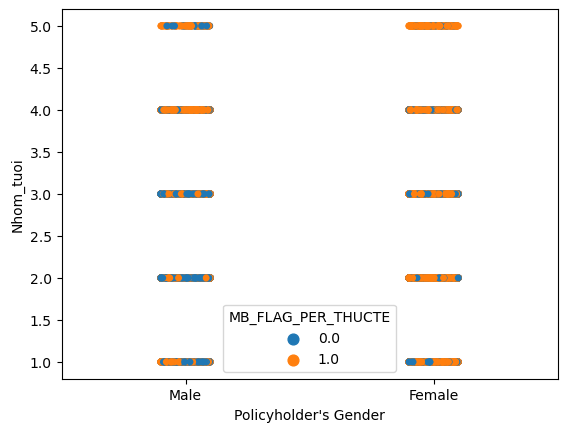

In [32]:
sns.stripplot(data=df_merge, x="Policyholder's Gender", y='Nhom_tuoi', hue='MB_FLAG_PER_THUCTE')
plt.show()

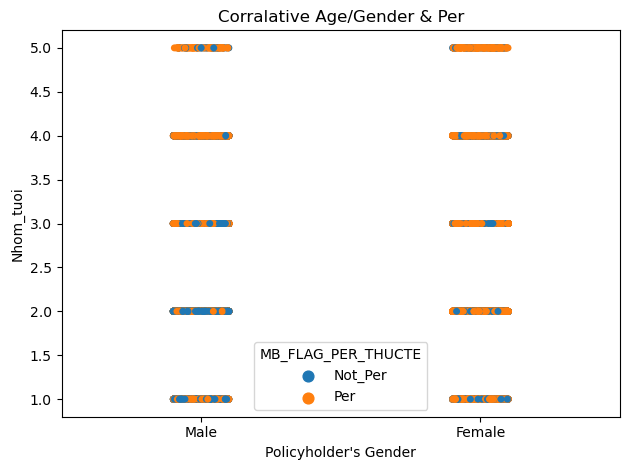

In [95]:
sns.stripplot(data=df_temp, x="Policyholder's Gender", y='Nhom_tuoi', hue='MB_FLAG_PER_THUCTE')
plt.title('Corralative Age/Gender & Per')
plt.show()

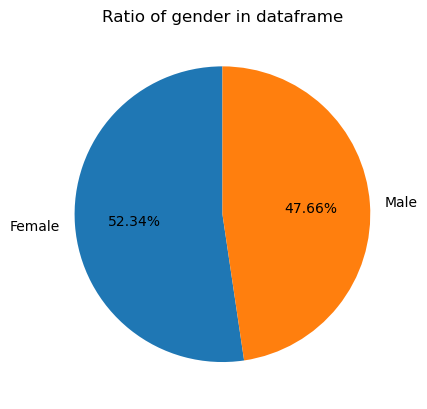

In [34]:
plt.pie(df_temp["Policyholder's Gender"].value_counts(), labels=df_merge["Policyholder's Gender"].value_counts().index, startangle=90, autopct='%.2f%%')
plt.title('Ratio of gender in dataframe')
plt.show()

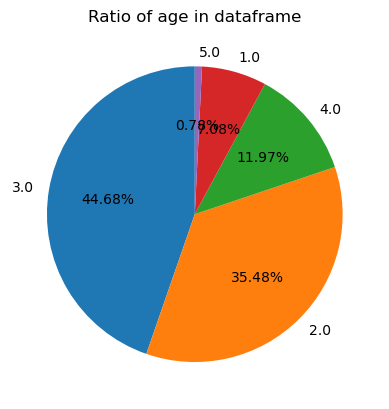

In [35]:
plt.pie(df_temp["Nhom_tuoi"].value_counts(), labels=df_merge["Nhom_tuoi"].value_counts().index, startangle=90, autopct='%.2f%%')
plt.title('Ratio of age in dataframe')
plt.show()

#### Some useful insights about Age corralative with target:

**- Age mostly between 26-50 yo and Male_Per have more mean age than Male_NoPer / Female got similar mean age in both type Per**<br>
**- Male with age between 35 and 50 has more potential to renewal their policies**<br>
**- Male in age group 26-35 yo get a lot of Persistency**<br>
**- Most Persistency for Male is in 51-65 yo**<br>
**- Higher age of Female has more chance to renewal (>65 yo)**<br>

E. Pending corralative with Persistency:

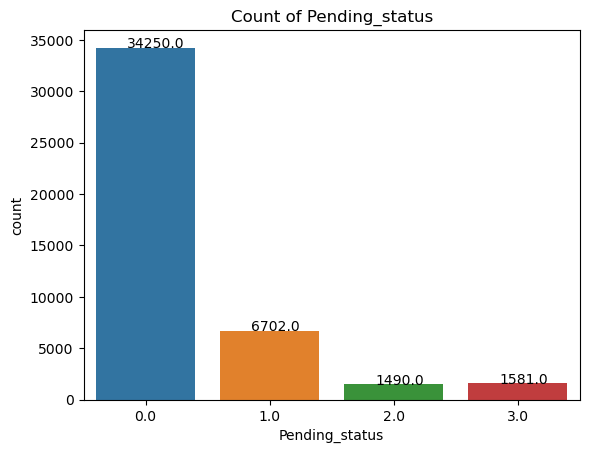

In [36]:
ax=sns.countplot(data=df_temp,x="Pending_status")
plt.title("Count of Pending_status")
plt.rcParams["figure.autolayout"] = True
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

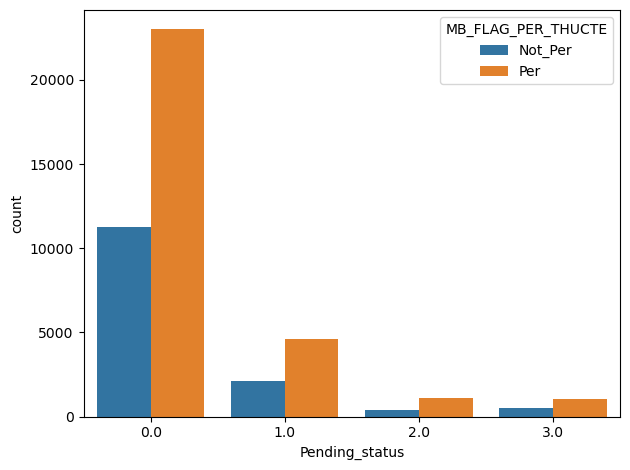

In [37]:
sns.countplot(data=df_temp,x="Pending_status",hue="MB_FLAG_PER_THUCTE")
plt.show()

In [39]:
df_temp["Pending_status"].value_counts(normalize=True)

0.0    0.778002
1.0    0.152239
3.0    0.035913
2.0    0.033846
Name: Pending_status, dtype: float64

**=> Mostly Per in good health customers (pending=0) and ratio of targets is quite similar to eachother; obviously cause of high number normal customers. So we can assume that health status does not affect Per**

F. Payment Frequency distribution:

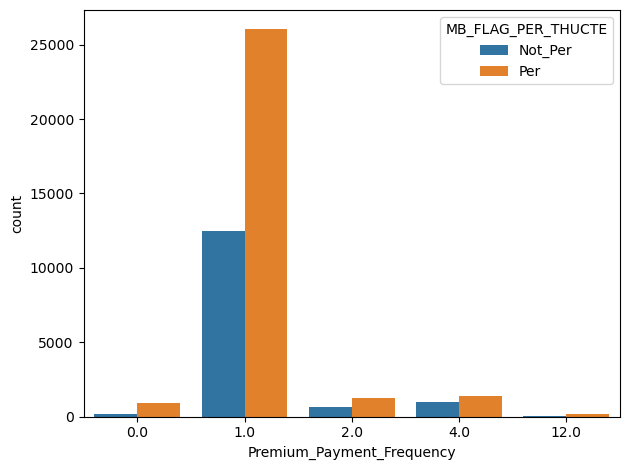

In [40]:
sns.countplot(data=df_temp,x="Premium_Payment_Frequency",hue="MB_FLAG_PER_THUCTE")
plt.show()

**=> Payment frequency has the same distribution as health status so we assume that payment frequency does not affect Per**

G. Customer segmentation:

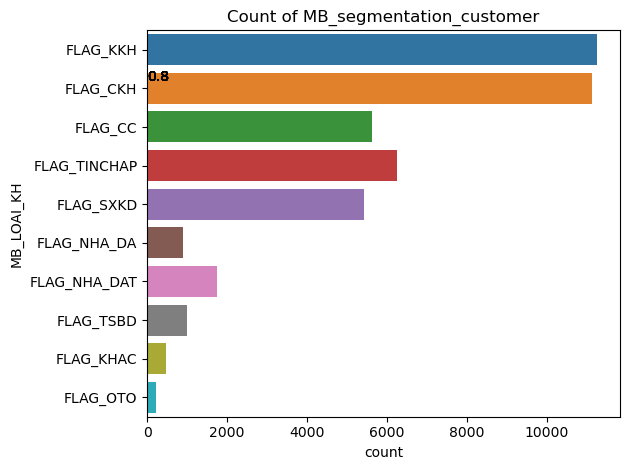

In [38]:
ax=sns.countplot(data=df_temp,y="MB_LOAI_KH")
plt.title("Count of MB_segmentation_customer")
plt.rcParams["figure.autolayout"] = True
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

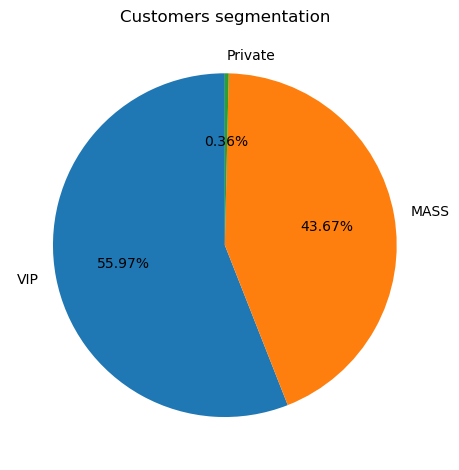

In [42]:
plt.pie(df_merge['MB_PHAN_KHUC_KH'].value_counts(), labels=df_merge['MB_PHAN_KHUC_KH'].value_counts().index, startangle=90, autopct='%.2f%%')
plt.title('Customers segmentation')
plt.show

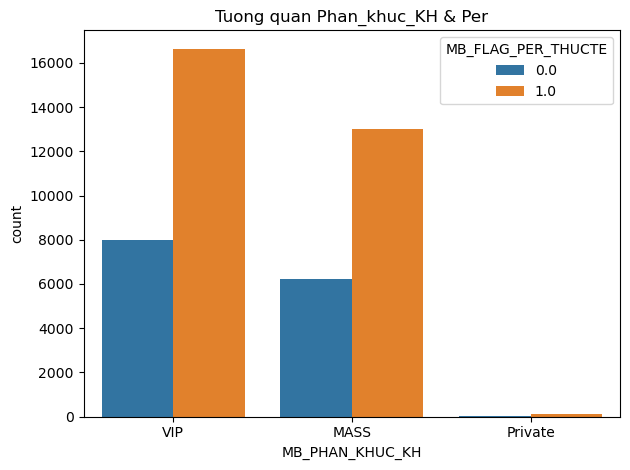

In [43]:
sns.countplot(data=df_merge, x='MB_PHAN_KHUC_KH', hue='MB_FLAG_PER_THUCTE')
plt.title('Tuong quan Phan_khuc_KH & Per')
plt.show()

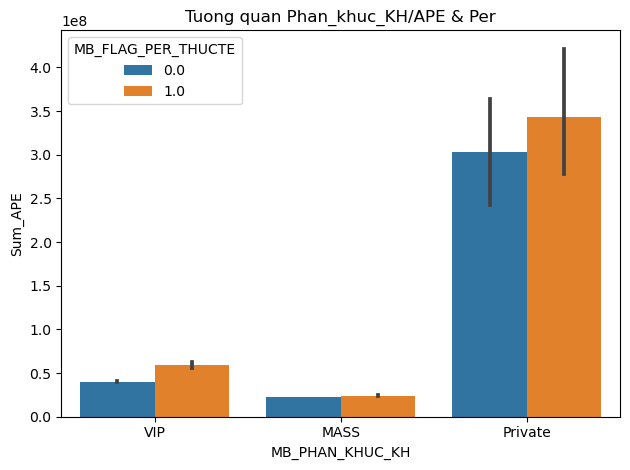

In [44]:
sns.barplot(data=df_merge, x='MB_PHAN_KHUC_KH',y='Sum_APE' ,hue='MB_FLAG_PER_THUCTE')
plt.title('Tuong quan Phan_khuc_KH/APE & Per')
plt.show()

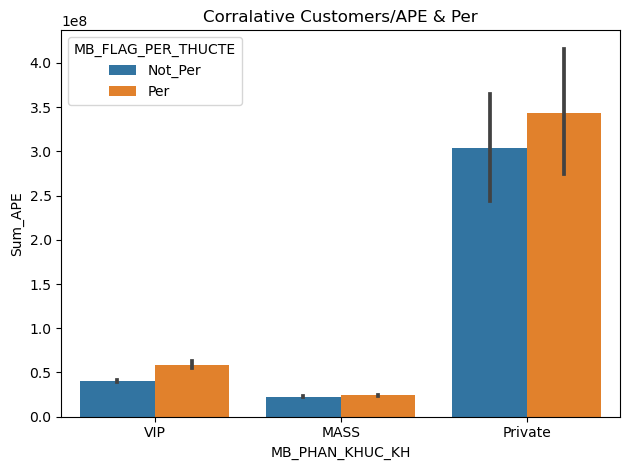

In [45]:
sns.barplot(data=df_temp, x='MB_PHAN_KHUC_KH',y='Sum_APE' ,hue='MB_FLAG_PER_THUCTE')
plt.title('Corralative Customers/APE & Per')
plt.show()

#### Some findings about customer segmentation:

**- Private Customers have less numbers but they have high APE and high ratio of persistency**<br>
**- VIP customers have more APE, get more ratio of persistency**<br>
**- Mass Customers have the same ratio of persistency**<br>

*** _Enhance EDA with mutiple variances_

In [51]:
# Select a subset of data that we assume does not affect Per above and compare with some other variances because there is still have a chance that a group of non affect could make more sence
df_muti_new_var = df_temp[['Nhom_tuoi','Pending_status','So_HD','Premium_Payment_Frequency','MB_FLAG_PER_THUCTE']]
df_muti_new_var

,Nhom_tuoi,Pending_status,So_HD,Premium_Payment_Frequency,MB_FLAG_PER_THUCTE
0,3.0,1.0,1.0,1.0,Not_Per
1,4.0,0.0,1.0,1.0,Per
2,3.0,0.0,1.0,1.0,Per
3,2.0,0.0,1.0,1.0,Not_Per
4,2.0,0.0,1.0,1.0,Not_Per
...,...,...,...,...,...
44048,2.0,0.0,1.0,1.0,Not_Per
44049,3.0,0.0,1.0,1.0,Per
44050,2.0,1.0,1.0,1.0,Not_Per
44051,2.0,0.0,1.0,1.0,Not_Per


In [52]:
# check for correlative, we could also visualize this with heatmap 
df_muti_new_var.corr

<bound method DataFrame.corr of        Nhom_tuoi  Pending_status  So_HD  Premium_Payment_Frequency  \
0            3.0             1.0    1.0                        1.0   
1            4.0             0.0    1.0                        1.0   
2            3.0             0.0    1.0                        1.0   
3            2.0             0.0    1.0                        1.0   
4            2.0             0.0    1.0                        1.0   
...          ...             ...    ...                        ...   
44048        2.0             0.0    1.0                        1.0   
44049        3.0             0.0    1.0                        1.0   
44050        2.0             1.0    1.0                        1.0   
44051        2.0             0.0    1.0                        1.0   
44052        3.0             0.0    1.0                        4.0   

      MB_FLAG_PER_THUCTE  
0                Not_Per  
1                    Per  
2                    Per  
3                No

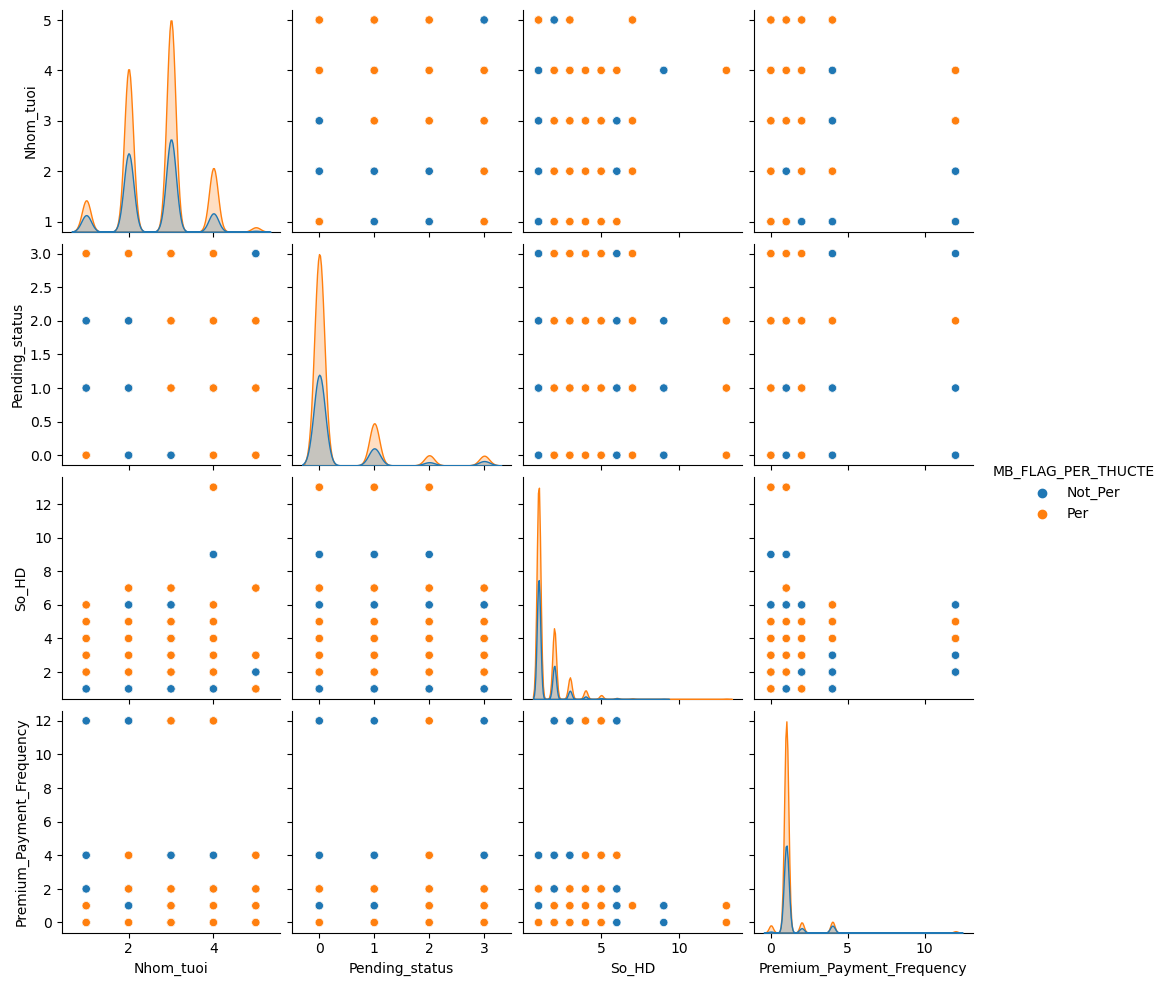

In [53]:
sns.pairplot(data = df_muti_new_var,
            hue='MB_FLAG_PER_THUCTE',
            diag_kind='kde',
            kind="scatter"
            );

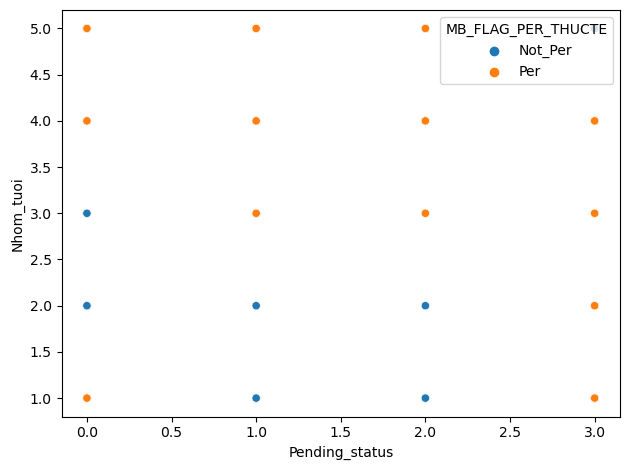

In [54]:
df_muti_pd_age = df_temp[["Pending_status","Nhom_tuoi","MB_FLAG_PER_THUCTE"]]
sns.scatterplot(data = df_muti_pd_age,
            hue='MB_FLAG_PER_THUCTE',
            x="Pending_status",
            y="Nhom_tuoi"
            );

**=> After check for corralation, we know that Pending status and Payment frequency is really no affect to Per**

In [55]:
# We continue pick another subset of data for analysis, this time we choose customer's finance information
df_muti_mb_var = df_merge[['MB_SODU_CASA',"MB_SODU_TK","MB_TONGDUNO","MB_DUNO_VISA","MB_SLSP","MB_SLDV","MB_SLSP_MBAL","MB_FLAG_PER_THUCTE"]]

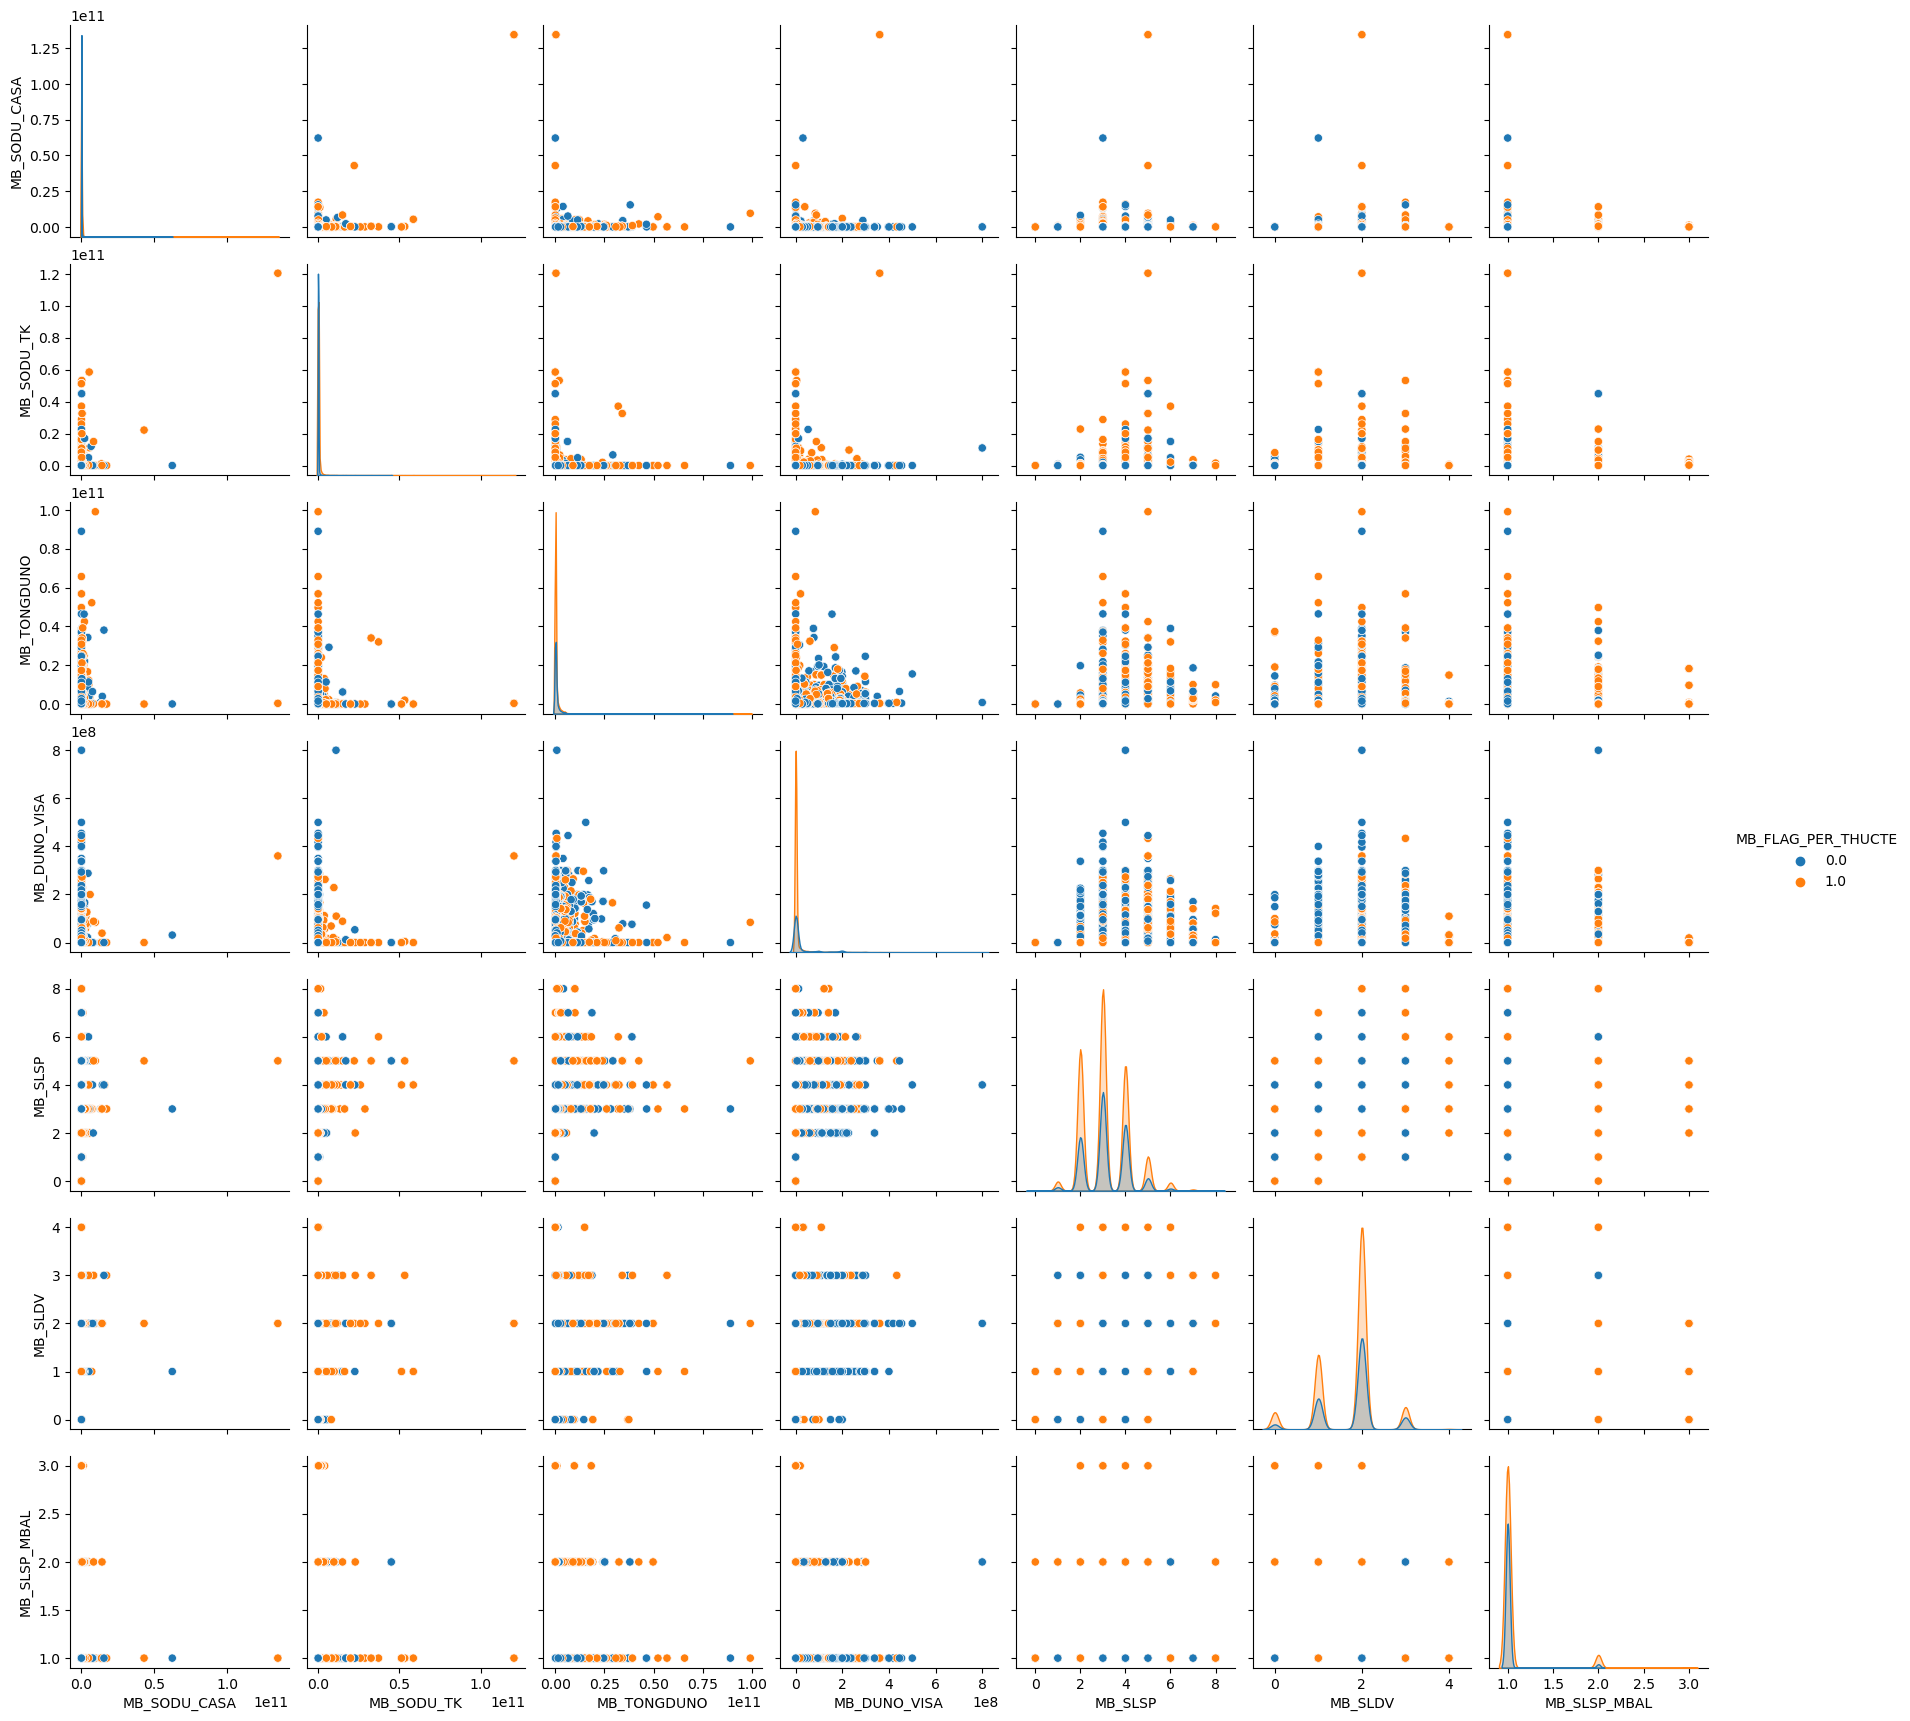

In [56]:
sns.pairplot(data = df_muti_mb_var,
            hue='MB_FLAG_PER_THUCTE',
            diag_kind='kde',
            kind="scatter"
            );

#### Some useful insights:

**- Customers with more SODU_TK or SLSP_MBAL have more chance to renewal policies**<br>
**- Customers with high DU_NO_VISA and also high SODU_TK have high chance to renewal policies**<br>

## III. Implement with ScikitLearn

In [57]:
### Transform data input with one-hot encode (using get_dummies):

df_dum = pd.get_dummies(df_merge)
df_dum

,MB_CREDIT_LIMIT_CC,MB_SDBQ_CASA_6M,MB_SDBQ_TK_3M,MB_SDBQ_TK_1M,MB_FLAG_KH_ACTIVE,MB_SODU_CASA,MB_SDBQ_CASA_3M,MB_SDBQ_CASA_1M,MB_SODU_TK,MB_FLAG_TK_3M,...,MBAL_HOLDER_CIVIL_STATUS_Widowed,region_MB,region_MN,region_MT,Policyholder's Gender_Female,Policyholder's Gender_Male,Policy Status_Active,Policy Status_Dormant,Policy Status_Lapse,Policy Status_Reversed
0,0.0,3.610298e+07,0.000000e+00,0.0,1.0,2709716.0,1.178853e+07,1.153869e+07,0.0,0.0,...,0,1,0,0,0,1,1,0,0,0
1,30000000.0,1.090826e+03,3.000875e+08,300259776.0,1.0,691.0,6.910000e+02,6.910000e+02,301610560.0,1.0,...,0,1,0,0,1,0,1,0,0,0
2,100000000.0,3.326200e+08,1.077625e+09,458330560.0,1.0,407009536.0,3.391443e+08,6.295462e+08,0.0,1.0,...,0,0,0,1,1,0,1,0,0,0
3,200000000.0,1.117808e+06,0.000000e+00,0.0,1.0,130549.0,1.855181e+06,3.873062e+05,0.0,0.0,...,0,0,1,0,0,1,1,0,0,0
4,0.0,3.707526e+04,0.000000e+00,0.0,1.0,6.0,2.174051e+04,6.451826e+04,0.0,0.0,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44048,200000000.0,1.222250e+08,4.565881e+06,0.0,1.0,36281616.0,2.600879e+07,2.383796e+07,0.0,1.0,...,0,1,0,0,0,1,1,0,0,0
44049,35000000.0,8.479791e+05,0.000000e+00,0.0,1.0,138006.0,1.090732e+06,5.437092e+05,0.0,0.0,...,0,0,1,0,1,0,1,0,0,0
44050,30000000.0,9.312354e+05,0.000000e+00,0.0,1.0,4009575.0,1.010904e+06,1.279810e+06,0.0,0.0,...,0,0,1,0,0,1,1,0,0,0
44051,20000000.0,1.050187e+07,0.000000e+00,0.0,1.0,14209067.0,1.610872e+07,3.274732e+07,0.0,0.0,...,0,0,1,0,0,1,1,0,0,0


In [58]:
## check if df_dum get any null values:
for column in df_dum.columns:
        while df_dum[column].isnull().sum() != 0:
            print(column,df_dum[column].isnull().sum())
        else:
            print('No null values remain. You are good to go!')
            break

No null values remain. You are good to go!


In [59]:
# get to deep understand of how your data distribute with describe method
df_dum.describe()

,MB_CREDIT_LIMIT_CC,MB_SDBQ_CASA_6M,MB_SDBQ_TK_3M,MB_SDBQ_TK_1M,MB_FLAG_KH_ACTIVE,MB_SODU_CASA,MB_SDBQ_CASA_3M,MB_SDBQ_CASA_1M,MB_SODU_TK,MB_FLAG_TK_3M,...,MBAL_HOLDER_CIVIL_STATUS_Widowed,region_MB,region_MN,region_MT,Policyholder's Gender_Female,Policyholder's Gender_Male,Policy Status_Active,Policy Status_Dormant,Policy Status_Lapse,Policy Status_Reversed
count,4.402300e+04,4.402300e+04,4.402300e+04,4.402300e+04,44023.000000,4.402300e+04,4.402300e+04,4.402300e+04,4.402300e+04,44023.000000,...,44023.000000,44023.000000,44023.000000,44023.000000,44023.000000,44023.000000,44023.000000,44023.000000,44023.000000,44023.000000
mean,4.503838e+07,4.931722e+07,1.831425e+08,1.805700e+08,0.930559,8.215457e+07,5.558902e+07,6.514976e+07,1.942591e+08,0.260773,...,0.000045,0.522204,0.272040,0.205756,0.523431,0.476569,0.939009,0.009245,0.025964,0.025782
std,8.047377e+07,2.733897e+08,1.486687e+09,1.489331e+09,0.254205,1.660586e+09,3.126509e+08,4.897690e+08,2.045787e+09,0.439061,...,0.006740,0.499512,0.445015,0.404258,0.499456,0.499456,0.239316,0.095707,0.159029,0.158486
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-4.987000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,8.139387e+05,0.000000e+00,0.000000e+00,1.000000,1.008140e+05,7.561642e+05,5.528462e+05,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,7.252420e+06,0.000000e+00,0.000000e+00,1.000000,3.133527e+06,7.090278e+06,6.041358e+06,0.000000e+00,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000e+08,3.199005e+07,2.021739e+07,1.190323e+07,1.000000,2.324286e+07,3.306516e+07,3.198723e+07,3.749729e+06,1.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000e+09,1.445984e+10,5.842052e+10,5.852352e+10,1.000000,1.344890e+11,1.525628e+10,3.052602e+10,1.204830e+11,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
# take a total corralative, we could also use heatmap but I want to see a big picture in here
df_dum.corr()

,MB_CREDIT_LIMIT_CC,MB_SDBQ_CASA_6M,MB_SDBQ_TK_3M,MB_SDBQ_TK_1M,MB_FLAG_KH_ACTIVE,MB_SODU_CASA,MB_SDBQ_CASA_3M,MB_SDBQ_CASA_1M,MB_SODU_TK,MB_FLAG_TK_3M,...,MBAL_HOLDER_CIVIL_STATUS_Widowed,region_MB,region_MN,region_MT,Policyholder's Gender_Female,Policyholder's Gender_Male,Policy Status_Active,Policy Status_Dormant,Policy Status_Lapse,Policy Status_Reversed
MB_CREDIT_LIMIT_CC,1.000000,0.228864,0.221124,0.219694,0.131068,0.176454,0.221299,0.203269,0.253271,-0.010591,...,-0.003772,-0.087032,0.165037,-0.074137,-0.056251,0.056251,-0.028829,0.014375,0.015844,0.018953
MB_SDBQ_CASA_6M,0.228864,1.000000,0.182172,0.185560,0.047781,0.622837,0.953883,0.824712,0.502210,0.044161,...,-0.000501,-0.005992,0.038816,-0.035326,-0.005575,0.005575,0.007197,-0.005811,-0.007098,-0.000236
MB_SDBQ_TK_3M,0.221124,0.182172,1.000000,0.992342,0.033652,0.043673,0.126432,0.076807,0.712037,0.154772,...,-0.000830,0.051005,-0.022753,-0.037976,0.052315,-0.052315,0.004417,-0.006803,-0.017434,0.014931
MB_SDBQ_TK_1M,0.219694,0.185560,0.992342,1.000000,0.033120,0.048174,0.128492,0.088028,0.720245,0.154833,...,-0.000817,0.049447,-0.022540,-0.036286,0.052365,-0.052365,0.004672,-0.006641,-0.017422,0.014438
MB_FLAG_KH_ACTIVE,0.131068,0.047781,0.033652,0.033120,1.000000,0.013454,0.048248,0.036132,0.025940,0.162248,...,0.001841,0.072341,-0.028389,-0.058137,-0.035760,0.035760,-0.012863,0.008648,-0.006534,0.020758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Policyholder's Gender_Male,0.056251,0.005575,-0.052315,-0.052365,0.035760,-0.007245,0.006220,-0.003721,-0.046342,-0.220850,...,0.007064,-0.065452,0.039205,0.037716,-1.000000,1.000000,-0.027825,0.038985,0.045554,-0.027235
Policy Status_Active,-0.028829,0.007197,0.004417,0.004672,-0.012863,0.005125,0.007355,0.005029,0.005162,0.014955,...,-0.012365,0.018265,-0.008654,-0.013042,0.027825,-0.027825,1.000000,-0.379033,-0.640617,-0.638311
Policy Status_Dormant,0.014375,-0.005811,-0.006803,-0.006641,0.008648,-0.002406,-0.005534,-0.003771,-0.005591,-0.022236,...,-0.000651,-0.023063,-0.004118,0.033030,-0.038985,0.038985,-0.379033,1.000000,-0.015771,-0.015715
Policy Status_Lapse,0.015844,-0.007098,-0.017434,-0.017422,-0.006534,-0.002990,-0.007670,-0.002774,-0.013802,-0.052725,...,-0.001100,-0.055728,0.035969,0.029264,-0.045554,0.045554,-0.640617,-0.015771,1.000000,-0.026560


In [61]:
# we split our dataset into 2 parts: Features matrix and Target vector

### Feature matrix X:
X = df_dum.drop(columns=['MB_FLAG_PER_THUCTE'])

### Target Y:
Y = df_dum['MB_FLAG_PER_THUCTE']

### Do resampling with data dumm input:

A. Under-sampling with NearMiss technique

In [62]:
nm = NearMiss()

X_nm, Y_nm = nm.fit_resample(X,Y)

In [63]:
### use Min-Max scaler:
scaler = MinMaxScaler()
X_nm = scaler.fit_transform(X_nm)

In [64]:
### Split Input DataFrame into Train/Test: 80% for Train & 20% for Test:
X_nm_train, X_nm_test, Y_nm_train, Y_nm_test = train_test_split(X_nm, Y_nm, test_size=0.2, random_state=20)

#### |=> We first try with LogisticRegression model

In [65]:
# simple logistic regression model:

model_nm_lr = LogisticRegression(fit_intercept=False)
model_nm_lr.fit(X_nm_train,Y_nm_train)
Y_nm_lr_predict = model_nm_lr.predict(X_nm_test)

In [66]:
# get valuate scores for this model
print(f'Accuracy_score = ',accuracy_score(Y_nm_test, Y_nm_lr_predict))
print(f'Precision_score = ',precision_score(Y_nm_test, Y_nm_lr_predict))
print(f'Recall_score = ',recall_score(Y_nm_test, Y_nm_lr_predict))
print(f'F1_score = ',f1_score(Y_nm_test, Y_nm_lr_predict))
print('\n')
print(classification_report(Y_nm_lr_predict,Y_nm_test))

Accuracy_score =  0.7271931360532307
Precision_score =  0.691724573594441
Recall_score =  0.79004329004329
F1_score =  0.7376220949814752


              precision    recall  f1-score   support

         0.0       0.67      0.77      0.72      2545
         1.0       0.79      0.69      0.74      3166

    accuracy                           0.73      5711
   macro avg       0.73      0.73      0.73      5711
weighted avg       0.74      0.73      0.73      5711



In [67]:
print(confusion_matrix(Y_nm_lr_predict,Y_nm_test))

[[1963  582]
 [ 976 2190]]


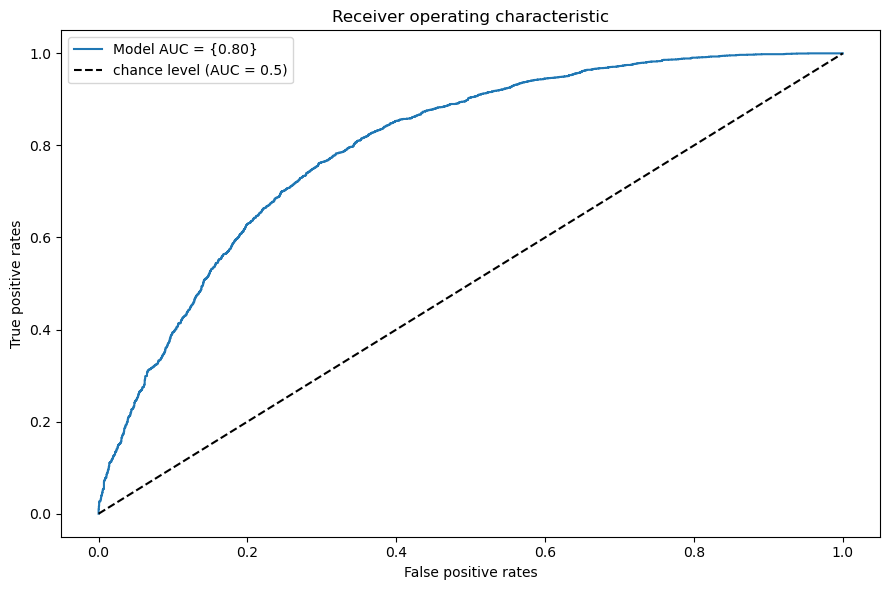

In [68]:
plt.figure(figsize=(9,6))
fpr, tpr, thresholds = roc_curve(Y_nm_test, model_nm_lr.predict_proba(X_nm_test)[:,1])
roc_au_s = roc_auc_score(Y_nm_test, model_nm_lr.predict_proba(X_nm_test)[:,1])

plt.plot(fpr,tpr, label="Model AUC = {%.2f}" %roc_au_s)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rates")
plt.ylabel("True positive rates")
plt.legend()
plt.show()

#### |=> Now try XGBoost model

In [69]:
### Use XGBoost Model:

model_nm_xgb = XGBClassifier()

In [70]:
model_nm_xgb.fit(X_nm_train,Y_nm_train)
Y_nm_xgb_predict = model_nm_xgb.predict(X_nm_test)

In [71]:
# get the evaluate scores with this model:
print(f'Accuracy_score = ',accuracy_score(Y_nm_test, Y_nm_xgb_predict))
print(f'Precision_score = ',precision_score(Y_nm_test, Y_nm_xgb_predict))
print(f'Recall_score = ',recall_score(Y_nm_test, Y_nm_xgb_predict))
print(f'F1_score = ',f1_score(Y_nm_test, Y_nm_xgb_predict))
print('\n')
print(classification_report(Y_nm_xgb_predict,Y_nm_test))

Accuracy_score =  0.8115916652074943
Precision_score =  0.7719692110327133
Recall_score =  0.8683261183261183
F1_score =  0.8173174872665535


              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2593
           1       0.87      0.77      0.82      3118

    accuracy                           0.81      5711
   macro avg       0.81      0.82      0.81      5711
weighted avg       0.82      0.81      0.81      5711



In [72]:
print(confusion_matrix(Y_nm_xgb_predict,Y_nm_test))

[[2228  365]
 [ 711 2407]]


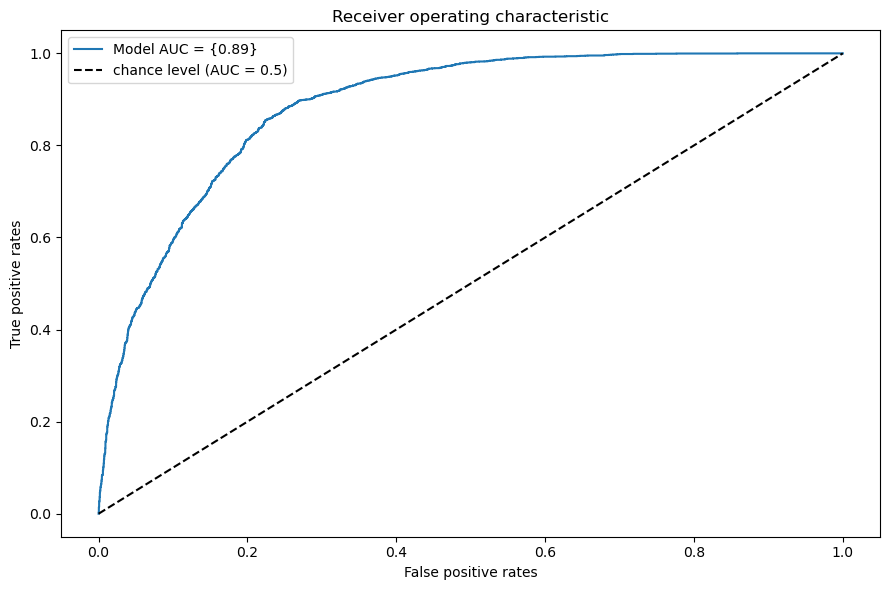

In [73]:
plt.figure(figsize=(9,6))
fpr, tpr, thresholds = roc_curve(Y_nm_test, model_nm_xgb.predict_proba(X_nm_test)[:,1])
roc_au_s = roc_auc_score(Y_nm_test, model_nm_xgb.predict_proba(X_nm_test)[:,1])

plt.plot(fpr,tpr, label="Model AUC = {%.2f}" %roc_au_s)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rates")
plt.ylabel("True positive rates")
plt.legend()
plt.show()

=> Conclusion with Under-sampling after try 2 models:<br>
**XGBoost got higher score / AUC than LogisticRegression**

B. Use Over-sampling with SMOTE technique

In [74]:
### assign model
sm = SMOTE()
X_sm, Y_sm = sm.fit_resample(X,Y)

In [75]:
### use Min-Max scaler:
scaler = MinMaxScaler()
X_sm = scaler.fit_transform(X_sm)

In [76]:
### Split Input DataFrame into Train/Test: 80% for Train & 20% for Test:
X_sm_train, X_sm_test, Y_sm_train, Y_sm_test = train_test_split(X_sm, Y_sm, test_size=0.2, random_state=20)

#### |=> We try LogisticRegression model fisrt with this

In [77]:
# Use LogisticRegression Model:

model_sm_lr = LogisticRegression(fit_intercept=False)
model_sm_lr.fit(X_sm_train,Y_sm_train)
Y_sm_lr_predict = model_sm_lr.predict(X_sm_test)

In [78]:
# get evaluate scores with this model:
print(f'Accuracy_score = ',accuracy_score(Y_sm_test, Y_sm_lr_predict))
print(f'Precision_score = ',precision_score(Y_sm_test, Y_sm_lr_predict))
print(f'Recall_score = ',recall_score(Y_sm_test, Y_sm_lr_predict))
print(f'F1_score = ',f1_score(Y_sm_test, Y_sm_lr_predict))
print('\n')
print(classification_report(Y_sm_lr_predict,Y_sm_test))

Accuracy_score =  0.7709891587528364
Precision_score =  0.7335058214747736
Recall_score =  0.8542015400066957
F1_score =  0.7892661047096127


              precision    recall  f1-score   support

         0.0       0.69      0.82      0.75      4942
         1.0       0.85      0.73      0.79      6957

    accuracy                           0.77     11899
   macro avg       0.77      0.78      0.77     11899
weighted avg       0.78      0.77      0.77     11899



In [79]:
print(confusion_matrix(Y_sm_lr_predict,Y_sm_test))

[[4071  871]
 [1854 5103]]


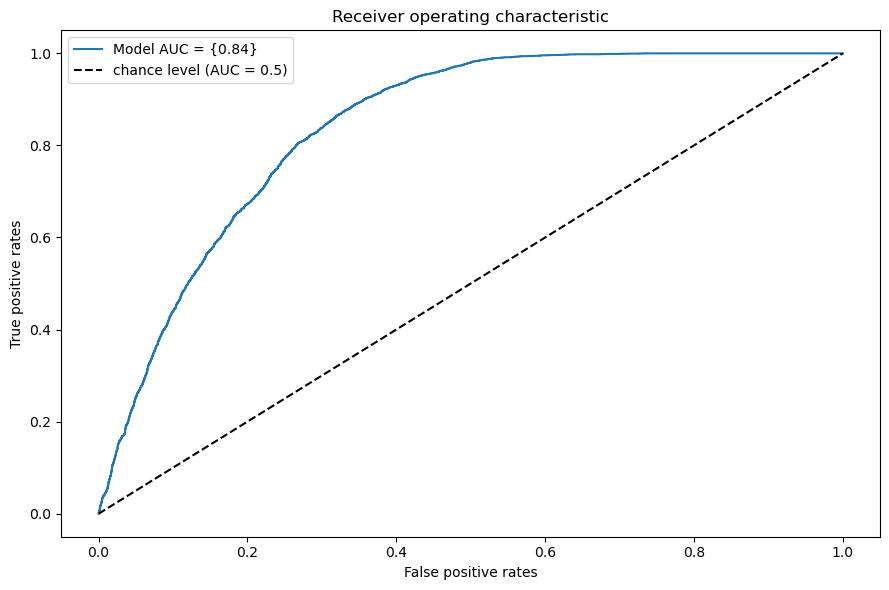

In [80]:
plt.figure(figsize=(9,6))
fpr, tpr, thresholds = roc_curve(Y_sm_test, model_sm_lr.predict_proba(X_sm_test)[:,1])
roc_au_s = roc_auc_score(Y_sm_test, model_sm_lr.predict_proba(X_sm_test)[:,1])

plt.plot(fpr,tpr, label="Model AUC = {%.2f}" %roc_au_s)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rates")
plt.ylabel("True positive rates")
plt.legend()
plt.show()

#### |=> Now we try XGBoost model

In [81]:
### Use XGBoost Model:

model_sm_xgb = XGBClassifier()

In [82]:
model_sm_xgb.fit(X_sm_train,Y_sm_train)
Y_sm_xgb_predict = model_sm_xgb.predict(X_sm_test)

In [83]:
# get evaluate scores for this model:
print(f'Accuracy_score = ',accuracy_score(Y_sm_test, Y_sm_xgb_predict))
print(f'Precision_score = ',precision_score(Y_sm_test, Y_sm_xgb_predict))
print(f'Recall_score = ',recall_score(Y_sm_test, Y_sm_xgb_predict))
print(f'F1_score = ',f1_score(Y_sm_test, Y_sm_xgb_predict))
print('\n')
print(classification_report(Y_sm_xgb_predict,Y_sm_test))

Accuracy_score =  0.8485587024119674
Precision_score =  0.8148204044672502
Recall_score =  0.9037495815199197
F1_score =  0.8569841269841271


              precision    recall  f1-score   support

           0       0.79      0.89      0.84      5273
           1       0.90      0.81      0.86      6626

    accuracy                           0.85     11899
   macro avg       0.85      0.85      0.85     11899
weighted avg       0.85      0.85      0.85     11899



In [84]:
print(confusion_matrix(Y_sm_xgb_predict,Y_sm_test))

[[4698  575]
 [1227 5399]]


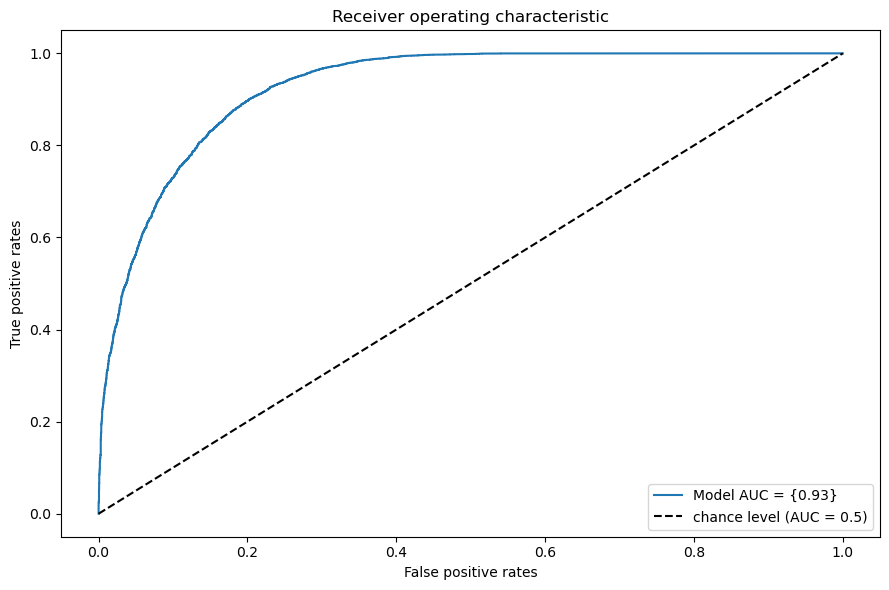

In [85]:
plt.figure(figsize=(9,6))
fpr, tpr, thresholds = roc_curve(Y_sm_test, model_sm_xgb.predict_proba(X_sm_test)[:,1])
roc_au_s = roc_auc_score(Y_sm_test, model_sm_xgb.predict_proba(X_sm_test)[:,1])

plt.plot(fpr,tpr, label="Model AUC = {%.2f}" %roc_au_s)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rates")
plt.ylabel("True positive rates")
plt.legend()
plt.show()

=> Conclusion after we try 2 methods to solve unbalance dataset:<br>
**XGBoost got higher score / AUC than LogisticRegression**<br>
**=>_So we gonna use XGBoost model with SMOTE technique due to the best scores it have_**

## IV. Apply model (optinal for a deeper test model)

In [96]:
### get the probality for X-feature:

X_test_proba=model_sm_xgb.predict_proba(X_sm_test)
X_test_proba

array([[4.37910974e-01, 5.62089026e-01],
       [2.99229741e-01, 7.00770259e-01],
       [3.29547405e-01, 6.70452595e-01],
       ...,
       [1.15529895e-01, 8.84470105e-01],
       [5.08326888e-02, 9.49167311e-01],
       [9.99241054e-01, 7.58952810e-04]], dtype=float32)

In [117]:
# convert probality into dataframe
df_proba = pd.DataFrame(X_test_proba)
df_proba.columns = ["Negative_proba","Positive_proba"]
df_X_test = pd.DataFrame(X_sm_test)
df_proba

,Negative_proba,Positive_proba
0,0.437911,0.562089
1,0.299230,0.700770
2,0.329547,0.670453
3,0.149638,0.850362
4,0.275945,0.724055
...,...,...
11894,0.997672,0.002328
11895,0.999460,0.000540
11896,0.115530,0.884470
11897,0.050833,0.949167


In [118]:
# merge probality with dataset (also can merge with inital dataset for a clearer meaning of each features)
df_test_with_proba = pd.concat([df_X_test,df_proba],axis=1)
df_test_with_proba

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,Negative_proba,Positive_proba
0,0.00,0.000106,0.000000e+00,0.000000e+00,1.0,0.000401,0.000201,0.000150,0.000000e+00,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.437911,0.562089
1,0.11,0.002841,0.000000e+00,0.000000e+00,1.0,0.000521,0.002060,0.000671,0.000000e+00,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.299230,0.700770
2,0.00,0.000000,1.446410e-03,1.443864e-03,1.0,0.000371,0.000000,0.000000,7.013438e-04,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.329547,0.670453
3,0.00,0.001445,1.180086e-02,1.241850e-02,1.0,0.000408,0.001237,0.000288,6.032171e-03,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.149638,0.850362
4,0.03,0.002131,0.000000e+00,0.000000e+00,1.0,0.000374,0.000515,0.000067,0.000000e+00,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.275945,0.724055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11894,0.00,0.002366,4.243205e-07,4.235737e-07,1.0,0.000509,0.002043,0.001855,2.057471e-07,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.997672,0.002328
11895,0.10,0.000354,0.000000e+00,0.000000e+00,1.0,0.000388,0.000194,0.000093,0.000000e+00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.999460,0.000540
11896,0.00,0.012240,0.000000e+00,0.000000e+00,1.0,0.001366,0.005178,0.003159,0.000000e+00,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.115530,0.884470
11897,0.00,0.000000,4.679126e-03,5.245754e-03,1.0,0.000371,0.000000,0.000000,2.548077e-03,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.050833,0.949167


In [121]:
# filter only proba above 80% ratio for a real check
df_test_with_proba_top80 = df_test_with_proba[df_test_with_proba["Positive_proba"] >= 0.8]
df_test_with_proba_top80

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,Negative_proba,Positive_proba
3,0.00,0.001445,0.011801,0.012418,1.0,0.000408,0.001237,0.000288,0.006032,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.149638,0.850362
6,0.10,0.000371,0.010146,0.010092,1.0,0.000376,0.000360,0.000246,0.004902,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.107416,0.892584
8,0.00,0.000394,0.001338,0.002050,1.0,0.000428,0.000458,0.000252,0.000996,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.056067,0.943933
15,0.00,0.000000,0.004731,0.004488,1.0,0.000371,0.000000,0.000000,0.002180,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.174981,0.825019
20,0.00,0.000000,0.032884,0.032216,1.0,0.000371,0.000000,0.000000,0.015466,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.027880,0.972120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11882,0.03,0.000409,0.000146,0.000002,1.0,0.000531,0.000439,0.000311,0.000001,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.034295,0.965705
11889,0.00,0.000264,0.001698,0.002003,1.0,0.000373,0.000360,0.000237,0.001079,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.108084,0.891916
11891,0.00,0.040870,0.000000,0.000000,1.0,0.003423,0.058620,0.017429,0.000000,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.199636,0.800364
11896,0.00,0.012240,0.000000,0.000000,1.0,0.001366,0.005178,0.003159,0.000000,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.115530,0.884470


In [ ]:
### Next action:
# - We apply model for new incoming values to get probality if that customer will renewal policy next year or not
# - Improving model with true results
# - Create and test more rules / smart features to increasing model scores

## Appendix: What if we dont do resampling?

In [87]:
### use Min-Max scaler:

scaler = MinMaxScaler()
X_raw = scaler.fit_transform(X)
X_raw_train, X_raw_test, Y_raw_train, Y_raw_test = train_test_split(X_raw,Y,test_size=0.2,random_state=20)

In [88]:
### apply XGBoost model:

model_xgb_raw = XGBClassifier()

In [89]:
model_xgb_raw.fit(X_raw_train,Y_raw_train)
Y_raw_xgb_predict = model_xgb_raw.predict(X_raw_test)

In [90]:
# get score with this model:
print(f'Accuracy_score = ',accuracy_score(Y_raw_test, Y_raw_xgb_predict))
print(f'Precision_score = ',precision_score(Y_raw_test, Y_raw_xgb_predict))
print(f'Recall_score = ',recall_score(Y_raw_test, Y_raw_xgb_predict))
print(f'F1_score = ',f1_score(Y_raw_test, Y_raw_xgb_predict))
print('\n')
print(classification_report(Y_raw_xgb_predict,Y_raw_test))

Accuracy_score =  0.7985235661555934
Precision_score =  0.808611729769859
Recall_score =  0.9182262687573765
F1_score =  0.8599399968419391


              precision    recall  f1-score   support

           0       0.55      0.77      0.64      2070
           1       0.92      0.81      0.86      6735

    accuracy                           0.80      8805
   macro avg       0.73      0.79      0.75      8805
weighted avg       0.83      0.80      0.81      8805



### => Conclusion: Use Resampling is better in this situation